<a href="https://colab.research.google.com/github/Pandu98-pkh/DeepLearning/blob/main/01.%20Week%201/Notebook%20Assigment/Classification%20Income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision
!pip install tensorflow
!pip install numpy pandas matplotlib scikit-learn
!pip install category_encoders

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # untuk membagi data menjadi data latih dan data uji
from sklearn.preprocessing import LabelEncoder, MinMaxScaler # untuk mengubah label kelas menjadi angka
from sklearn.feature_selection import SelectKBest, f_classif
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
import math

In [3]:
url = "https://raw.githubusercontent.com/Pandu98-pkh/DeepLearning/refs/heads/main/01.%20Week%201/Dataset/income.csv"

try:
  df = pd.read_csv(url).dropna()
except Exception as e:
  print(f"Error loading dataset: {e}")

In [4]:
df.sample(10) # menampilkan 10 sample data secara acak

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27368,53,Self-emp-inc,298215,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,>50K
48394,43,Private,435266,Doctorate,16,Separated,Exec-managerial,Not-in-family,White,Female,14084,0,60,United-States,>50K.
41765,29,Private,30070,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K.
33698,24,Private,219140,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,40,United-States,<=50K.
26172,59,Self-emp-inc,141326,Assoc-voc,11,Divorced,Prof-specialty,Not-in-family,White,Male,0,0,50,United-States,>50K
48679,34,Private,177437,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,60,United-States,<=50K.
23905,26,Private,151810,10th,6,Never-married,Farming-fishing,Not-in-family,Black,Male,0,0,40,United-States,<=50K
11335,50,Private,189811,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
6323,25,Private,55718,Some-college,10,Never-married,Tech-support,Own-child,White,Male,0,0,25,United-States,<=50K
8235,26,Self-emp-not-inc,233933,10th,6,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,32,United-States,<=50K


In [5]:
df.describe() # menampilkan statistik data

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,47621.000000,4.762100e+04,47621.000000,47621.000000,47621.000000,47621.000000
mean,38.640684,1.897271e+05,10.090821,1091.137649,87.853489,40.600050
std,13.558961,1.055695e+05,2.568320,7487.228336,404.010612,12.260345
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175840e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.782820e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.377200e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47621 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             47621 non-null  int64 
 1   workclass       47621 non-null  object
 2   fnlwgt          47621 non-null  int64 
 3   education       47621 non-null  object
 4   education-num   47621 non-null  int64 
 5   marital-status  47621 non-null  object
 6   occupation      47621 non-null  object
 7   relationship    47621 non-null  object
 8   race            47621 non-null  object
 9   sex             47621 non-null  object
 10  capital-gain    47621 non-null  int64 
 11  capital-loss    47621 non-null  int64 
 12  hours-per-week  47621 non-null  int64 
 13  native-country  47621 non-null  object
 14  income          47621 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.8+ MB


In [7]:
# Menghapus spasi tambahan dari kolom kategori jika ada
db = df.apply(lambda x: x.str.strip(' .') if x.dtype == "object" else x)
# Mengubah target menjadi biner (0 = <=50K, 1 = >50K)
db['income'] = LabelEncoder().fit_transform(db['income'])
# Memisahkan fitur numerik dan kategorikal
num_cols = db.drop(columns=['income']).select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = db.select_dtypes(include=['object']).columns.tolist()

# Mengonversi variabel kategori menggunakan One-Hot Encoding
encoder = TargetEncoder()
db_encoded = encoder.fit_transform(db[cat_cols], db['income'])
db = db.drop(columns=cat_cols).join(db_encoded)

# Normalisasi fitur numerik
scaler = MinMaxScaler()
db[num_cols] = scaler.fit_transform(db[num_cols])

# Memisahkan fitur (X) dan target (y)
X = db.drop(columns=['income']).values
y = db['income'].values

print(X, y) # menampilkan data fitur dan label

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


[[0.30136986 0.04413121 0.8        ... 0.25707351 0.30701068 0.24731133]
 [0.45205479 0.04805174 0.8        ... 0.25707351 0.30701068 0.24731133]
 [0.28767123 0.13758131 0.53333333 ... 0.25707351 0.30701068 0.24731133]
 ...
 [0.28767123 0.24537874 0.8        ... 0.25707351 0.30701068 0.24731133]
 [0.36986301 0.04844413 0.8        ... 0.27436075 0.30701068 0.24731133]
 [0.24657534 0.11491866 0.8        ... 0.25707351 0.30701068 0.24731133]] [0 0 0 ... 0 0 1]


In [8]:
# prompt: Mempersiapkan Rumus Evaluasi (Akurasi, Presisi, Recall, F1Squared, AUC, ROC)
# # Fungsinya untuk menghitung metrik evaluasi
# # Metrik evaluasi yang digunakan adalah akurasi, presisi, recall, F1-score, AUC, dan ROC

def evaluate_model(y_true, y_pred, y_prob):
    """
    Evaluates the model's performance using various metrics.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.
        y_prob: Predicted probabilities.

    Returns:
        A dictionary containing the evaluation metrics.
    """

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)


    # Calculate F1-squared
    f1_squared = f1**2

    evaluation_metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'F1-Squared': f1_squared,
        'AUC': auc_score,
        'ROC_AUC': roc_auc
    }

    return evaluation_metrics


In [9]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Displays a confusion matrix to evaluate the model, showing percentages.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.
        model_name: Name of the model.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum() * 100 # Calculate percentages based on total

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", # Display percentages with 2 decimal places
                xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
    plt.title(f'Confusion Matrix for {model_name} (Percentage)') # Update title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Iterasi setiap teks di dalam heatmap dan tambahkan tanda %
    for t in ax.texts:
        t.set_text(t.get_text() + " %")

    plt.show()

def plot_training_history(history, model_name):
    """
    Displays the training history of the model.

    Args:
        history: Training history object.
        model_name: Name of the model.
    """
    # Assuming history object has 'accuracy' and 'loss' keys for both training and validation
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    # Modified to use the 'loss' column from the history DataFrame
    plt.plot(history['epoch'], history['loss'], label='Training Loss')
    plt.title(f'{model_name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Removed the validation accuracy and loss plots as they are not available
    # in the current history DataFrame

    plt.show()


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [11]:
# prompt: Mengonversi Dataset Menjadi Tipe Tensor PyTorch

# Mengonversi data latih dan data uji menjadi tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)  # Reshape y_train_tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)  # Reshape y_test_tensor

# Membuat TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Membuat DataLoader
batch_size = 32  # Contoh ukuran batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# prompt: Menyusun Model Neural Network Sederhana pytorch

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model, define loss function, and optimizer
input_size = X_train.shape[1]
model = Net(input_size)

In [13]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [14]:
# Melatih model
num_epochs = 100 # Jumlah iterasi pelatihan
history = pd.DataFrame() # Menyimpan statistik pelatihan
for epoch in range(num_epochs):
    optimizer.zero_grad() # Mengatur gradien menjadi 0 sebelum melakukan backpropagation
    y_pred = model(X_train_tensor) # Memprediksi data latih
    loss = criterion(y_pred, y_train_tensor) # Menghitung loss
    loss.backward() # Backpropagation
    optimizer.step() # Update bobot
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, loss={loss.item()}')
    # Menyimpan statistik pelatihan untuk menampilkan plot
    history = pd.concat([history, pd.DataFrame({'epoch': [epoch], 'loss': [loss.item()]})], ignore_index=True)

Epoch 0, loss=0.6734685301780701
Epoch 10, loss=0.5625782608985901
Epoch 20, loss=0.5049843192100525
Epoch 30, loss=0.41828426718711853
Epoch 40, loss=0.36908334493637085
Epoch 50, loss=0.35572728514671326
Epoch 60, loss=0.34685590863227844
Epoch 70, loss=0.3412559926509857
Epoch 80, loss=0.3372265100479126
Epoch 90, loss=0.3336314558982849


In [15]:
# Evaluation
y_pred_list = []
y_prob_list = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_prob_list.extend(outputs.numpy())
        predicted = (outputs > 0.5).float() # Convert probabilities to binary predictions
        y_pred_list.extend(predicted.numpy())

y_pred_list = np.array(y_pred_list).reshape(-1)
y_prob_list = np.array(y_prob_list).reshape(-1)
#Evaluate the model
metrics = evaluate_model(y_test, y_pred_list, y_prob_list)
print(metrics)

{'Accuracy': 0.8431496062992127, 'Precision': 0.7377139701822197, 'Recall': 0.5673036093418259, 'F1-Score': 0.6413826212193952, 'F1-Squared': 0.4113716668022621, 'AUC': 0.899981996227499, 'ROC_AUC': 0.899981996227499}


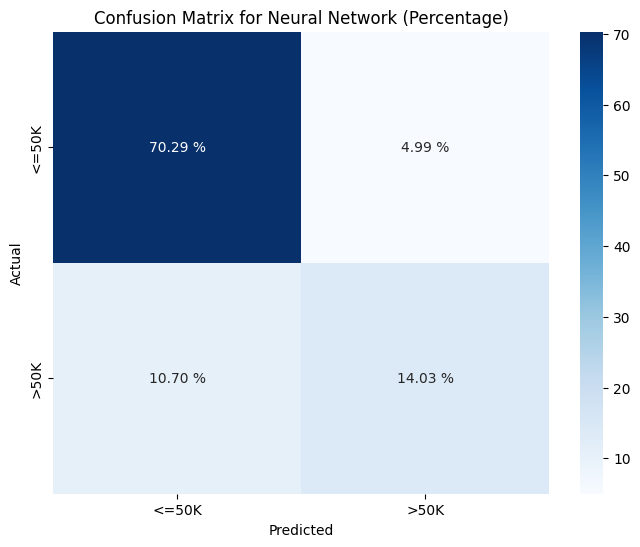

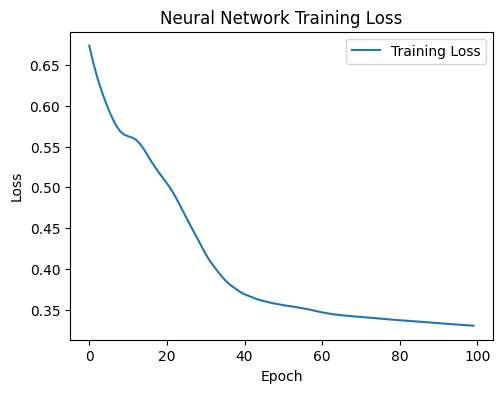

In [16]:
# prompt: Memvisualisasikan Prediksi dari model yang telah dilatih
#  plot_confusion_matrix(y_true, y_pred, model_name):
# def plot_training_history(history, model_name)

plot_confusion_matrix(y_test, y_pred_list, 'Neural Network')
# Assuming 'history' is available from the model training
plot_training_history(history, 'Neural Network')


In [37]:
# Pemeriksaan Konfigurasi Sistem
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [38]:
# Reinisialisasi Model dengan Konfigurasi Aman
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
# Compile the model
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 14), dtype=float32). Expected shape (None, 28, 28), but input has incompatible shape (None, 14)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 14), dtype=float32)
  • training=True
  • mask=None

In [31]:
# Evaluate the model
y_pred_prob = model_tf.predict(X_test)  # Use model_tf instead of model
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

metrics = evaluate_model(y_test, y_pred, y_pred_prob)
print(metrics)

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-30-14f9d3ea382a>", line 2, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_1274]

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'TensorFlow Neural Network')
plot_training_history(history.history, 'TensorFlow Neural Network')

In [44]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-44-69c4ede183a4>", line 18, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_4639]